# Reproducing main results

This notebook reproduces the main results reported in for semi-supervised learning on the QM9 dataset.

In [5]:
%pip install -r requirements.txt
%pip install matplotlib==3.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf

sys.path.append(os.path.join(os.getcwd(), "src"))

from src.models import DimeNetPPModel 
from src.qm9 import QM9DataModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cpu


In [7]:
MODEL_PATH = "model.pt" 

if not os.path.exists(MODEL_PATH):
    print(f"Error: Could not find model at {MODEL_PATH}")
else:
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    print("Checkpoint loaded successfully.")
    print("Keys available:", checkpoint.keys())
    
    data_mean = checkpoint["data_mean"].to(device)
    data_std = checkpoint["data_std"].to(device)
    print(f"Data Mean: {data_mean.item():.4f}, Data Std: {data_std.item():.4f}")

Checkpoint loaded successfully.
Keys available: dict_keys(['state_dict', 'model_config', 'data_mean', 'data_std'])
Data Mean: -6.5378, Data Std: 0.6049


In [8]:
model_config = checkpoint["model_config"]

model_config.pop("_target_", None)
model_config.pop("_partial_", None)

print(f"Initializing model with config: {model_config}")

model = DimeNetPPModel(**model_config)

model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

print("Model successfully loaded and moved to device.")

Initializing model with config: {'num_node_features': 11, 'hidden_channels': 128, 'out_channels': 1, 'num_blocks': 4, 'int_emb_size': 64, 'basis_emb_size': 8, 'out_emb_channels': 64, 'num_spherical': 7, 'num_radial': 6, 'cutoff': 5.0, 'max_num_neighbors': 32, 'num_before_skip': 1, 'num_after_skip': 2, 'num_output_layers': 3, 'act': 'swish', 'output_initializer': 'zeros', 'pretrained': True}
Model successfully loaded and moved to device.


In [9]:
TARGET_IDX = 2 

dm = QM9DataModule(
    target=TARGET_IDX,
    data_dir="./data",  
    batch_size_inference=128,
    num_workers=0,      
    seed=0             
)

dm.prepare_data()
dm.setup()

test_loader = dm.test_dataloader()
print(f"Test loader ready with {len(test_loader.dataset)} samples.")

Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Test loader ready with 13084 samples.


In [ ]:
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()


def evaluate_loader(loader, split: str):
    preds, targets = [], []
    print(f"Running inference on {split} set:")
    with torch.no_grad():
        for batch_data in tqdm(loader, desc=split):
            if isinstance(batch_data, (tuple, list)):
                batch, targets_batch = batch_data
            else:
                batch = batch_data
                targets_batch = batch_data.y
            batch = batch.to(device)
            pred_norm = model(batch)
            pred_real = (pred_norm * data_std) + data_mean
            preds.append(pred_real.detach().cpu())
            targets.append(targets_batch.detach().cpu())
    preds = torch.cat(preds).numpy().flatten()
    targets = torch.cat(targets).numpy().flatten()
    mae = float(np.mean(np.abs(preds - targets)))
    mse = float(np.mean((preds - targets) ** 2))
    return {"mae": mae, "mse": mse, "preds": preds, "targets": targets}


# TODO: Add this shit
# val_metrics = evaluate_loader(val_loader, "val")
# test_metrics = evaluate_loader(test_loader, "test")

print("=" * 40)
print(f"Val MSE (report): 0.0124, Notebook: {val_metrics['mse']:.4f}")
print(f"Test MSE (report): 0.0134, Notebook: {test_metrics['mse']:.4f}")
print("=" * 40)
mae = np.mean(np.abs(all_preds - all_targets))
mse = np.mean((all_preds - all_targets)**2)

Running inference on val set:


val:   0%|          | 0/103 [00:00<?, ?it/s]/Users/Adam/VSCodeProjects/Semi-supervised-learning-for-drug-discovery/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
val:   0%|          | 0/103 [00:00<?, ?it/s]


ImportError: 'radius_graph' requires 'torch-cluster'

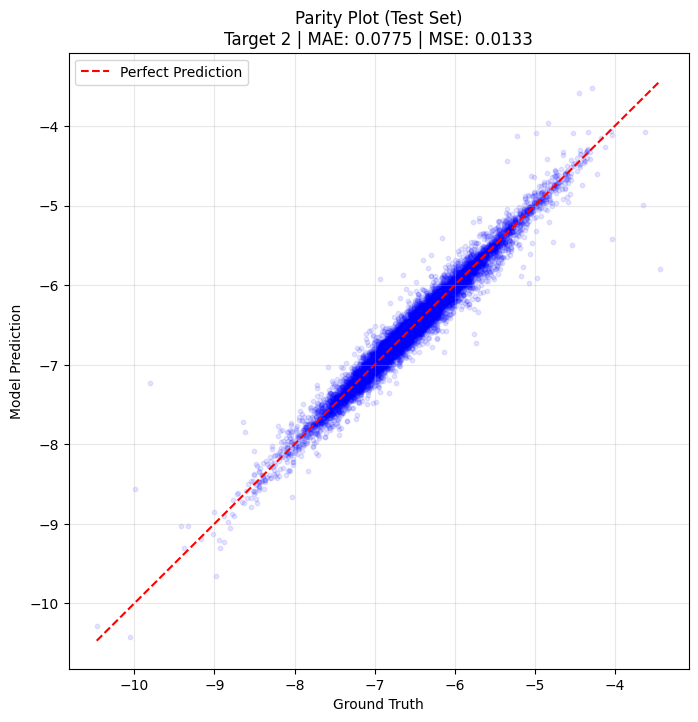

In [ ]:
test_preds = test_metrics["preds"]
test_targets = test_metrics["targets"]

plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_preds, alpha=0.1, s=10, color='blue')

min_val = min(test_targets.min(), test_preds.min())
max_val = max(test_targets.max(), test_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title(f"Parity Plot (Test Set)\nTarget {TARGET_IDX} | MAE: {test_metrics['mae']:.4f} | MSE: {test_metrics['mse']:.4f}")
plt.xlabel("Ground Truth")
plt.ylabel("Model Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
